In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x28cc8230148>,
 'station': 'USC00519397',
 'prcp': 0.08,
 'tobs': 65.0,
 'id': 1,
 'date': '2010-01-01'}

In [12]:
twelve_months= session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(twelve_months)

('2017-08-23',)


In [13]:
prev_year = dt.date(2017, 8 ,23) - dt.timedelta(days=36)
print(prev_year)

2017-07-18


In [14]:
query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year).all()

In [15]:
prcp_df = pd.DataFrame(query,columns=['date', 'precipitation'])

In [16]:
prcp_df['date'] = pd.to_datetime(prcp_df['date'], format='%Y-%m-%d')
prcp_df.set_index('date', inplace=True)
prcp_df = prcp_df.sort_values(by='date',ascending=True)

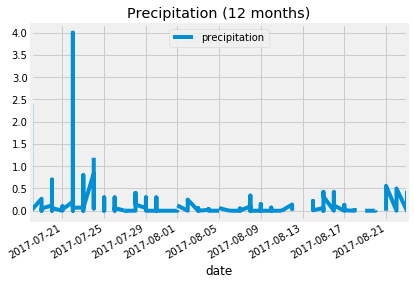

In [17]:
prcp_df .plot(title="Precipitation (12 months)")
plt.legend(loc='upper center')
plt.show()

In [18]:
prcp_df.describe()

,precipitation
count,166.000000
mean,0.127169
std,0.394252
min,0.000000
25%,0.000000
50%,0.010000
75%,0.090000
max,4.000000


In [19]:
primer_row = session.query(Station).first()
primer_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x28cc8623d48>,
 'id': 1,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'elevation': 3.0,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168}

In [20]:
stations = session.query(Measurement.station).distinct().count()
print(stations)

9


In [21]:
mas_activas = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
print(mas_activas)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [22]:
number_one=mas_activas[0][0]
print(number_one)

USC00519281


In [23]:
temp_alta = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == number_one).all()
print(temp_alta)

[(54.0, 85.0, 71.66378066378067)]


In [1]:
estaciones = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
estaciones= estaciones[0]

temp_twelve = session.query( Measurement.tobs).filter(Measurement.date >= prev_year).filter(Measurement.station == estaciones).all()
temp_twelve = pd.DataFrame(temp_twelve, columns=['tobs'])

temp_twelve.plot.hist(bins=12)
plt.show()

![precipitation](Images/station-histogram.png)

In [29]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [37]:
viaje = calc_temps('2015-05-16','2015-05-19')
viaje

[(68.0, 74.60714285714286, 82.0)]

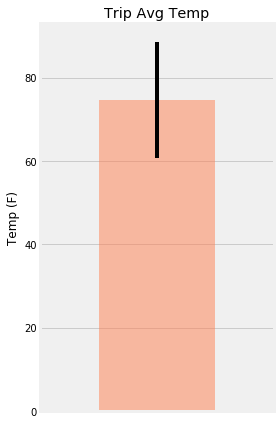

In [36]:
temp_df = pd.DataFrame(viaje, columns=['tmin', 'tavg', 'tmax'])

temp_df.plot.bar(y='tavg', yerr=(temp_df['tmax'] - temp_df['tmin']), title='Trip Avg Temp', color='coral', alpha=0.5, figsize=(4,6))
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.gca().legend_.remove()
plt.show()

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]
